COMP396: Molecular property prediction with coulomb matrix representation


D. C. Elton, Z. Boukouvalas, M. S. Butrico, M. D. Fuge, and P. W. Chung, “Applying machine learning techniques to predict the properties of energetic materials”, Scientific Reports 8, 9059 (2018).



In [0]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable

import time
import argparse
import os
import numpy as np

In [2]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

--2019-09-25 01:32:30--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##



In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [4]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls "/content/drive/My Drive/dsb4"

dsgdb9nsd_000001.xyz  dsgdb9nsd_001001.xyz  dsgdb9nsd_002001.xyz
dsgdb9nsd_000002.xyz  dsgdb9nsd_001002.xyz  dsgdb9nsd_002002.xyz
dsgdb9nsd_000003.xyz  dsgdb9nsd_001003.xyz  dsgdb9nsd_002003.xyz
dsgdb9nsd_000004.xyz  dsgdb9nsd_001004.xyz  dsgdb9nsd_002004.xyz
dsgdb9nsd_000005.xyz  dsgdb9nsd_001005.xyz  dsgdb9nsd_002005.xyz
dsgdb9nsd_000006.xyz  dsgdb9nsd_001006.xyz  dsgdb9nsd_002006.xyz
dsgdb9nsd_000007.xyz  dsgdb9nsd_001007.xyz  dsgdb9nsd_002007.xyz
dsgdb9nsd_000008.xyz  dsgdb9nsd_001008.xyz  dsgdb9nsd_002008.xyz
dsgdb9nsd_000009.xyz  dsgdb9nsd_001009.xyz  dsgdb9nsd_002009.xyz
dsgdb9nsd_000010.xyz  dsgdb9nsd_001010.xyz  dsgdb9nsd_002010.xyz
dsgdb9nsd_000011.xyz  dsgdb9nsd_001011.xyz  dsgdb9nsd_002011.xyz
dsgdb9nsd_000012.xyz  dsgdb9nsd_001012.xyz  dsgdb9nsd_002012.xyz
dsgdb9nsd_000013.xyz  dsgdb9nsd_001013.xyz  dsgdb9nsd_002013.xyz
dsgdb9nsd_000014.xyz  dsgdb9nsd_001014.xyz  dsgdb9nsd_002014.xyz
dsgdb9nsd_000015.xyz  dsgdb9nsd_001015.xyz  dsgdb9nsd_002015.xyz
dsgdb9nsd_000016.xyz  dsg

In [0]:
root = "/content/drive/My Drive/dsb4/"


In [7]:
file_list = os.listdir(root)
num_mols = len(file_list)
print(num_mols)

3000


In [0]:
def read_xyz(file_name):
    with open(file_name, 'rb') as file:
        num_atoms = int(file.readline())
        properties = file.readline().split()[1:17]
        properties = [num.replace(b'*^', b'e') for num in properties] 
        properties = [float(prop) for prop in properties]
        atom_types = [0]*num_atoms
        coords = np.array(np.zeros([num_atoms,3]))
        for na in range(num_atoms):
            coord_line = file.readline().split()
            atom_types[na] = coord_line[0]
            xyz_coords = coord_line[1:4]
            xyz_coords = [num.replace(b'*^', b'e') for num in xyz_coords] 
            coords[na,:] = [float(num) for num in xyz_coords]  
        vib_freqs = file.readline()
        smiles = file.readline().split()[0]
        inchis = file.readline()
        
    return smiles, properties, atom_types, coords


In [9]:
smiles = [0]*num_mols
properties = [0]*num_mols 
atom_types = [0]*num_mols
coords = [0]*num_mols

for im in range(num_mols):
    smiles[im], properties[im], atom_types[im], coords[im] = read_xyz(root+file_list[im])

biggest_mol_size = max([len(atom_list) for atom_list in atom_types])

print("size of largest molecule = ", biggest_mol_size)

size of largest molecule =  23


In [10]:
#Data exploration
print(smiles[0])
print(properties[0])
print(atom_types[0])
print(coords[0])

b'CCC(C)(C)CO'
[1190.0, 4.21306, 1.59526, 1.58608, 1.3701, 70.35, -0.2634, 0.071, 0.3344, 930.2807, 0.19263, -312.126404, -312.116983, -312.116038, -312.159466, 34.624]
[b'C', b'C', b'C', b'C', b'C', b'C', b'O', b'H', b'H', b'H', b'H', b'H', b'H', b'H', b'H', b'H', b'H', b'H', b'H', b'H', b'H']
[[-0.09154256  1.53218101  0.14093275]
 [ 0.02343999  0.01390489 -0.03527386]
 [ 0.74930904 -0.47568921 -1.31226983]
 [ 0.01338755 -0.01015841 -2.58249908]
 [ 2.20950203  0.01284022 -1.34298298]
 [ 0.73909444 -2.01433855 -1.26566411]
 [ 1.39435776 -2.52844238 -2.41775037]
 [ 0.89004214  2.01290774  0.19180415]
 [-0.64962172  1.99719149 -0.67729967]
 [-0.61895248  1.76670105  1.07100844]
 [ 0.54132136 -0.40287972  0.83946119]
 [-0.98646587 -0.4185391  -0.0229258 ]
 [ 0.06357126  1.07628402 -2.69885767]
 [ 0.45972962 -0.46759113 -3.46842875]
 [-1.04456084 -0.29659295 -2.55229845]
 [ 2.73477263 -0.25682968 -0.41908737]
 [ 2.74456645 -0.44382452 -2.17874483]
 [ 2.26592257  1.09932994 -1.45601355]
 [

In [0]:
import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole 
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions 

In [0]:
DrawingOptions.bondLineWidth=2.0
sample= Chem.MolFromSmiles(smiles[0])

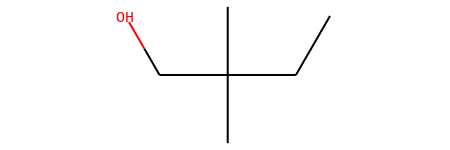

In [13]:
sample

In [14]:
all_atoms = []
for atoms in atom_types:
    all_atoms += atoms
print(set(all_atoms))
del all_atoms

{b'F', b'H', b'C', b'O', b'N'}


In [15]:
!git clone https://github.com/bmbodj/mmltoolkit.git

fatal: destination path 'mmltoolkit' already exists and is not an empty directory.


In [16]:
!ls mmltoolkit

examples  LICENSE  mmltoolkit  README.md  setup.py


In [17]:
!ls mmltoolkit/mmltoolkit

CV_tools.py			__init__.py
descriptors.py			learning_curves.py
feature_importance.py		metrics.py
featurization_comparison.py	model_comparison.py
featurizations.py		__pycache__
fingerprints.py			test_everything.py
functional_group_featurizer.py	test_splits.py


In [0]:
# Add these modules to my mounted path
sys.path.append('/content/drive/My Drive/')

In [19]:
import mmltoolkit

from mmltoolkit.mmltoolkit.featurizations import coulombmat_eigenvalues_from_coords

coulombmat_eigenvalues_from_coords(atom_types[1], coords[1], biggest_mol_size)

array([ 1.60917481e+02,  4.72751900e+01,  3.39339068e+01,  2.42747076e+01,
        1.97015339e+01,  1.40277910e+01,  6.27681243e+00, -1.01069264e+00,
       -9.08256183e-01, -8.18211511e-01, -8.13453030e-01, -5.24708481e-01,
        5.67776020e-02,  9.89253696e-03, -2.27927089e-02, -3.65468361e-02,
       -7.38508871e-02, -1.21301963e-01, -1.40791073e-01, -1.71724450e-01,
       -1.66436759e-01,  0.00000000e+00,  0.00000000e+00])

In [0]:
# Generate Coulomb matrix eigenvalues 
cmat_eigs = np.zeros([num_mols, biggest_mol_size])

for im in range(num_mols):
    cmat_eigs[im,:] = coulombmat_eigenvalues_from_coords(atom_types[im], coords[im], biggest_mol_size)

In [21]:
cmat_eigs.shape

(3000, 23)

In [0]:
from google.colab import files

In [0]:
with open('QM9_all_smiles.txt', 'wb') as file:
    for smile in smiles:
        file.write(smile+b'\n')

In [0]:
files.download('QM9_all_smiles.txt')

In [0]:
import pandas as pd
import numpy as np

In [30]:
dtype = [('Col1','int32'), ('Col2','float32'), ('Col3','float32'),('Col4','int32'), ('Col5','float32'), ('Col6','float32'),('Col7','int32'), ('Col8','float32'), ('Col9','float32'),('Col10','int32'), ('Col11','float32'), ('Col12','float32'),('Col13','float32'), ('Col14','float32'),('Col15','float32'), ('Col16','float32'),('Col17','float32')]
values = properties
index = ['Row'+str(i) for i in range(1, len(values)+1)]

df = pd.DataFrame(values, index=index)

df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Row1,1190.0,4.21306,1.59526,1.58608,1.3701,70.35,-0.2634,0.0710,0.3344,930.2807,0.192630,-312.126404,-312.116983,-312.116038,-312.159466,34.624
Row2,1191.0,3.19752,2.02748,1.75763,1.0638,70.74,-0.2456,0.0788,0.3244,886.0660,0.191831,-312.122563,-312.113075,-312.112131,-312.156051,34.466
Row3,1187.0,4.34167,1.63660,1.63065,2.6199,63.41,-0.2604,0.0669,0.3272,871.3942,0.168887,-348.048844,-348.039503,-348.038559,-348.081890,33.492
Row4,1196.0,8.34619,1.16060,1.04324,3.2208,62.34,-0.2392,0.0298,0.2690,1094.2800,0.111076,-324.588239,-324.579399,-324.578455,-324.624091,28.741
Row5,1195.0,8.48546,1.13674,1.02138,2.3414,66.31,-0.2392,-0.0110,0.2282,1140.7997,0.121157,-308.518356,-308.509288,-308.508344,-308.555292,29.102


In [0]:
len(df)

In [0]:
X=cmat_eigs
y_mu=df[df.columns[1]]
y_alpha=df[df.columns[2]]
y_homo=df[df.columns[3]]
y_lumo=df[df.columns[4]]
y_gap=df[df.columns[5]]
y_R2=df[df.columns[6]]
y_zpve=df[df.columns[7]]
y_u0=df[df.columns[8]]
y_u=df[df.columns[9]]
y_h=df[df.columns[10]]
y_g=df[df.columns[11]]
y_cv=df[df.columns[12]]


In [33]:
# Split X and y into training and testing/validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_mu, test_size=0.2, random_state=101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2400, 23)
(600, 23)
(2400,)
(600,)


In [0]:
from sklearn import preprocessing
X_scaled = preprocessing.scale(X_train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_traindtm=scaler.transform(X_train) 
X_testdtm=scaler.transform(X_test)

In [0]:
# Logitic regression model
from sklearn.linear_model import LinearRegression

In [0]:
logmodel=LinearRegression()

In [0]:
logmodel.fit(X_traindtm, y_train)
y_pred_log=logmodel.predict(X_testdtm)

In [0]:
# Import metrics to calculate accuracy
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

In [39]:
print("Mean absolute error score for logistic regression :")
print(mean_absolute_error(y_test,y_pred_log))

Mean absolute error score for logistic regression :
654.2694437825041


In [41]:
#Predicting second property
X_train, X_test, y_train, y_test = train_test_split(X, y_alpha, test_size=0.2, random_state=101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2400, 23)
(600, 23)
(2400,)
(600,)


In [0]:
X_scaled = preprocessing.scale(X_train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_traindtm=scaler.transform(X_train) 
X_testdtm=scaler.transform(X_test)

In [0]:
logmodel=LinearRegression()
logmodel.fit(X_traindtm, y_train)
y_pred_log=logmodel.predict(X_testdtm)

In [44]:
print("Mean absolute error score for logistic regression :")
print(mean_absolute_error(y_test,y_pred_log))

Mean absolute error score for logistic regression :
1.9141180976430845


In [45]:
#Predicting second property
X_train, X_test, y_train, y_test = train_test_split(X, y_homo, test_size=0.2, random_state=101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2400, 23)
(600, 23)
(2400,)
(600,)


In [0]:
X_scaled = preprocessing.scale(X_train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_traindtm=scaler.transform(X_train) 
X_testdtm=scaler.transform(X_test)

In [0]:
logmodel=LinearRegression()
logmodel.fit(X_traindtm, y_train)
y_pred_log=logmodel.predict(X_testdtm)

In [49]:
print("Mean absolute error score for logistic regression :")
print(mean_absolute_error(y_test,y_pred_log))

Mean absolute error score for logistic regression :
1.3937977839762246


In [50]:
#Predicting third property
X_train, X_test, y_train, y_test = train_test_split(X, y_lumo, test_size=0.2, random_state=101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2400, 23)
(600, 23)
(2400,)
(600,)


In [0]:
X_scaled = preprocessing.scale(X_train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_traindtm=scaler.transform(X_train) 
X_testdtm=scaler.transform(X_test)

In [0]:
logmodel=LinearRegression()
logmodel.fit(X_traindtm, y_train)
y_pred_log=logmodel.predict(X_testdtm)

In [53]:
print("Mean absolute error score for logistic regression :")
print(mean_absolute_error(y_test,y_pred_log))

Mean absolute error score for logistic regression :
0.9645256318843012


In [54]:
#Predicting fourth property
X_train, X_test, y_train, y_test = train_test_split(X, y_gap, test_size=0.2, random_state=101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2400, 23)
(600, 23)
(2400,)
(600,)


In [0]:
X_scaled = preprocessing.scale(X_train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_traindtm=scaler.transform(X_train) 
X_testdtm=scaler.transform(X_test)

In [0]:
logmodel=LinearRegression()
logmodel.fit(X_traindtm, y_train)
y_pred_log=logmodel.predict(X_testdtm)

In [57]:
print("Mean absolute error score for logistic regression :")
print(mean_absolute_error(y_test,y_pred_log))

Mean absolute error score for logistic regression :
2.9914394867018235


In [58]:
#Predicting fifth property
X_train, X_test, y_train, y_test = train_test_split(X, y_R2, test_size=0.2, random_state=101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2400, 23)
(600, 23)
(2400,)
(600,)


In [0]:
X_scaled = preprocessing.scale(X_train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_traindtm=scaler.transform(X_train) 
X_testdtm=scaler.transform(X_test)

In [0]:
logmodel=LinearRegression()
logmodel.fit(X_traindtm, y_train)
y_pred_log=logmodel.predict(X_testdtm)

In [61]:
print("Mean absolute error score for logistic regression :")
print(mean_absolute_error(y_test,y_pred_log))

Mean absolute error score for logistic regression :
0.01646613216803292


In [89]:
#Predicting 6th property
X_train, X_test, y_train, y_test = train_test_split(X, y_zpve, test_size=0.2, random_state=101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2400, 23)
(600, 23)
(2400,)
(600,)


In [0]:
X_scaled = preprocessing.scale(X_train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_traindtm=scaler.transform(X_train) 
X_testdtm=scaler.transform(X_test)

In [0]:
logmodel=LinearRegression()
logmodel.fit(X_traindtm, y_train)
y_pred_log=logmodel.predict(X_testdtm)

In [92]:
print("Mean absolute error score for logistic regression :")
print(mean_absolute_error(y_test,y_pred_log))

Mean absolute error score for logistic regression :
0.02577292545675841


In [93]:
#Predicting 7th property
X_train, X_test, y_train, y_test = train_test_split(X, y_u0, test_size=0.2, random_state=101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2400, 23)
(600, 23)
(2400,)
(600,)


In [0]:
X_scaled = preprocessing.scale(X_train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_traindtm=scaler.transform(X_train) 
X_testdtm=scaler.transform(X_test)

In [0]:
logmodel=LinearRegression()
logmodel.fit(X_traindtm, y_train)
y_pred_log=logmodel.predict(X_testdtm)

In [96]:
print("Mean absolute error score for logistic regression :")
print(mean_absolute_error(y_test,y_pred_log))

Mean absolute error score for logistic regression :
0.03177027863908889


In [97]:
#Predicting 8th property
X_train, X_test, y_train, y_test = train_test_split(X, y_u, test_size=0.2, random_state=101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2400, 23)
(600, 23)
(2400,)
(600,)


In [0]:
X_scaled = preprocessing.scale(X_train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_traindtm=scaler.transform(X_train) 
X_testdtm=scaler.transform(X_test)

In [0]:
logmodel=LinearRegression()
logmodel.fit(X_traindtm, y_train)
y_pred_log=logmodel.predict(X_testdtm)

In [100]:
print("Mean absolute error score for logistic regression :")
print(mean_absolute_error(y_test,y_pred_log))

Mean absolute error score for logistic regression :
70.74007821282734


In [101]:
#Predicting 9th property
X_train, X_test, y_train, y_test = train_test_split(X, y_h, test_size=0.2, random_state=101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2400, 23)
(600, 23)
(2400,)
(600,)


In [0]:
X_scaled = preprocessing.scale(X_train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_traindtm=scaler.transform(X_train) 
X_testdtm=scaler.transform(X_test)

In [0]:
logmodel=LinearRegression()
logmodel.fit(X_traindtm, y_train)
y_pred_log=logmodel.predict(X_testdtm)

In [104]:
print("Mean absolute error score for logistic regression :")
print(mean_absolute_error(y_test,y_pred_log))

Mean absolute error score for logistic regression :
0.008560014871333364


In [105]:
#Predicting 9th property
X_train, X_test, y_train, y_test = train_test_split(X, y_g, test_size=0.2, random_state=101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2400, 23)
(600, 23)
(2400,)
(600,)


In [0]:
X_scaled = preprocessing.scale(X_train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_traindtm=scaler.transform(X_train) 
X_testdtm=scaler.transform(X_test)

In [107]:
print("Mean absolute error score for logistic regression :")
print(mean_absolute_error(y_test,y_pred_log))

Mean absolute error score for logistic regression :
315.9646356757058
